<a href="https://colab.research.google.com/github/NandaFerry/ClassificacaoConducao/blob/main/ClassificacaoConducao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pacotes necessários para instalação

In [176]:
# Instalando os pacotes necessários

!pip3 install pandas
!pip3 install graphviz
!pip3 install pydotplus
!pip install --upgrade scikit-learn==0.20.3
!pip3 install shap

import shap
import seaborn as sns
import pandas as pd
import pydotplus
import numpy as np
import xgboost as xgb

from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics #Obtem as métricas do scikit-learn para calcular a acurácia
from six import StringIO
from IPython.display import Image
from imblearn.over_sampling import SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit-learn-0.20.3.tar.gz (11.8 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled s

## Lendo o conjunto de dados

In [150]:
# Transformação do DataSet "Driving Behavior" (csv) em um data frame

df = pd.read_csv("dados3.csv")

## Análise exploratória

In [151]:
df.head(10)

AltitudeVariation  VehicleSpeedInstantaneous  VehicleSpeedAverage  \
0               -1.7                       9.91                57.57   
1               -1.6                       6.08                56.96   
2               -0.9                       2.70                56.25   
3               -0.2                       1.35                55.47   
4               -0.3                       0.00                54.62   
5                0.0                       0.00                53.77   
6                0.2                       0.00                52.88   
7                0.5                       0.00                51.93   
8                0.9                       0.00                50.96   
9               -0.4                      15.09                19.82   

   VehicleSpeedVariation  LongitudinalAcceleration  EngineLoad  \
0                  -3.83                      1.98       27.06   
1                  -3.83                      2.07       29.02   
2                  -3.38                      2.12       38.82   
3                  -1.35                      2.16       33.33   
4                  -1.35                      2.19       30.59   
5                   0.00                      2.24       29.41   
6                   0.00                      2.23       29.02   
7                   0.00                      2.25       31.76   
8                   0.00                      2.18       33.33   
9                   0.68                      0.78       12.55   

   EngineCoolantTemperature  ManifoldAbsolutePressure  EngineRPM  MassAirFlow  \
0                        78                       100        873         5.16   
1                        78                       100        866         5.87   
2                        78                       100        849         4.97   
3                        78                       100        795         5.41   
4                        78                       100        805         5.43   
5                        78                       100        813         5.09   
6                        78                       100        812         4.66   
7                        78                       100        803         4.66   
8                        78                       100        841         4.76   
9                        78                       110       2068        15.33   

   IntakeAirTemperature  VerticalAcceleration  FuelConsumptionAverage  \
0                    14                 -0.96                   13.13   
1                    14                 -1.02                   13.21   
2                    15                 -1.05                   13.21   
3                    14                 -1.05                   13.21   
4                    15                 -1.04                   13.21   
5                    15                 -1.03                   13.21   
6                    15                 -1.05                   13.21   
7                    15                 -1.04                   13.21   
8                    16                 -1.01                   13.21   
9                    20                 -0.24                   14.54   

       roadSurface                    traffic     drivingStyle  
0  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
1  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
2  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
3  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
4  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
5  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
6  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
7  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
8  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
9  SmoothCondition  NormalCongestionCondition  AggressiveStyle

In [152]:
df.dtypes

AltitudeVariation            float64
VehicleSpeedInstantaneous    float64
VehicleSpeedAverage          float64
VehicleSpeedVariation        float64
LongitudinalAcceleration     float64
EngineLoad                   float64
EngineCoolantTemperature       int64
ManifoldAbsolutePressure       int64
EngineRPM                      int64
MassAirFlow                  float64
IntakeAirTemperature           int64
VerticalAcceleration         float64
FuelConsumptionAverage       float64
roadSurface                   object
traffic                       object
drivingStyle                  object
dtype: object

In [153]:
# Valores de saída não pode ser nulos, e por isso as observações com valores ausentes de saída devem ser removidas(aprendizado supervisionado).

df = df.dropna(subset=['drivingStyle'])

In [154]:
labels = df['drivingStyle']
labels.head()

0    AggressiveStyle
1    AggressiveStyle
2    AggressiveStyle
3    AggressiveStyle
4    AggressiveStyle
Name: drivingStyle, dtype: object

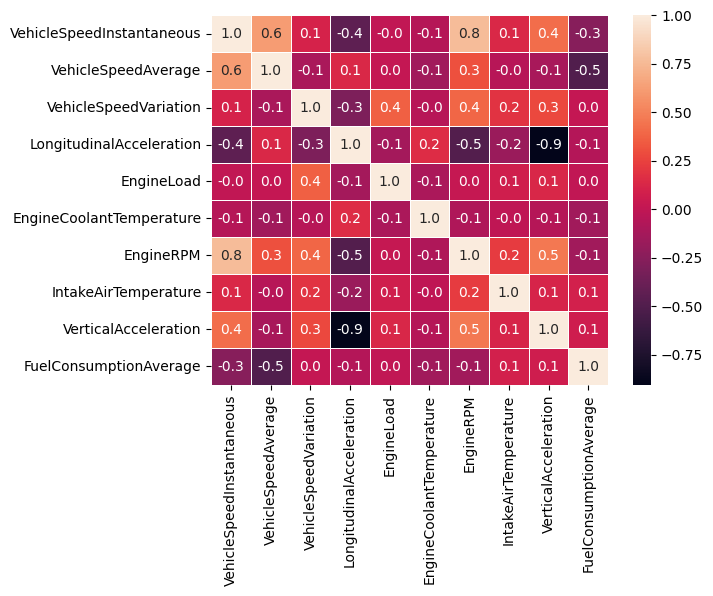

In [155]:
# Seleção de variaveis

features = [
    'VehicleSpeedInstantaneous', 'VehicleSpeedAverage',
    'VehicleSpeedVariation', 'LongitudinalAcceleration','EngineLoad',
    'EngineCoolantTemperature', 'EngineRPM', 'IntakeAirTemperature',
    'VerticalAcceleration', 'FuelConsumptionAverage'
]

correlation = df[features].corr()

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)


In [156]:
df[features]

VehicleSpeedInstantaneous  VehicleSpeedAverage  VehicleSpeedVariation  \
0                          9.91                57.57                  -3.83   
1                          6.08                56.96                  -3.83   
2                          2.70                56.25                  -3.38   
3                          1.35                55.47                  -1.35   
4                          0.00                54.62                  -1.35   
...                         ...                  ...                    ...   
2983                     110.79               114.25                   1.80   
2984                     110.79               114.08                   0.00   
2985                     111.69               113.91                   0.90   
2986                     111.01               113.69                  -0.68   
2987                     108.09               113.42                  -2.93   

      LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
0                         1.98       27.06                        78   
1                         2.07       29.02                        78   
2                         2.12       38.82                        78   
3                         2.16       33.33                        78   
4                         2.19       30.59                        78   
...                        ...         ...                       ...   
2983                      0.03       17.65                        82   
2984                      0.06       23.14                        82   
2985                      0.04       29.80                        82   
2986                      0.06       37.65                        82   
2987                      0.17       26.67                        81   

      EngineRPM  IntakeAirTemperature  VerticalAcceleration  \
0           873                    14                 -0.96   
1           866                    14                 -1.02   
2           849                    15                 -1.05   
3           795                    14                 -1.05   
4           805                    15                 -1.04   
...         ...                   ...                   ...   
2983       2216                    21                  0.14   
2984       2209                    20                  0.13   
2985       2208                    20                  0.10   
2986       2210                    21                  0.07   
2987       2214                    21                  0.14   

      FuelConsumptionAverage  
0                      13.13  
1                      13.21  
2                      13.21  
3                      13.21  
4                      13.21  
...                      ...  
2983                    9.63  
2984                    9.57  
2985                    9.50  
2986                    9.43  
2987                    9.36  

[2988 rows x 10 columns]

## Valores nulos

Valores ausentes para uma dada característica são substituídos pela média desta característica.

In [157]:
df = df.fillna(df.mean())

df.head()

<ipython-input-157-db926ddbb9c9>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


AltitudeVariation  VehicleSpeedInstantaneous  VehicleSpeedAverage  \
0               -1.7                       9.91                57.57   
1               -1.6                       6.08                56.96   
2               -0.9                       2.70                56.25   
3               -0.2                       1.35                55.47   
4               -0.3                       0.00                54.62   

   VehicleSpeedVariation  LongitudinalAcceleration  EngineLoad  \
0                  -3.83                      1.98       27.06   
1                  -3.83                      2.07       29.02   
2                  -3.38                      2.12       38.82   
3                  -1.35                      2.16       33.33   
4                  -1.35                      2.19       30.59   

   EngineCoolantTemperature  ManifoldAbsolutePressure  EngineRPM  MassAirFlow  \
0                        78                       100        873         5.16   
1                        78                       100        866         5.87   
2                        78                       100        849         4.97   
3                        78                       100        795         5.41   
4                        78                       100        805         5.43   

   IntakeAirTemperature  VerticalAcceleration  FuelConsumptionAverage  \
0                    14                 -0.96                   13.13   
1                    14                 -1.02                   13.21   
2                    15                 -1.05                   13.21   
3                    14                 -1.05                   13.21   
4                    15                 -1.04                   13.21   

       roadSurface                    traffic     drivingStyle  
0  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
1  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
2  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
3  SmoothCondition  NormalCongestionCondition  AggressiveStyle  
4  SmoothCondition  NormalCongestionCondition  AggressiveStyle

In [158]:

X = df[features] # Features
y = df.drivingStyle # Variavel de classificação

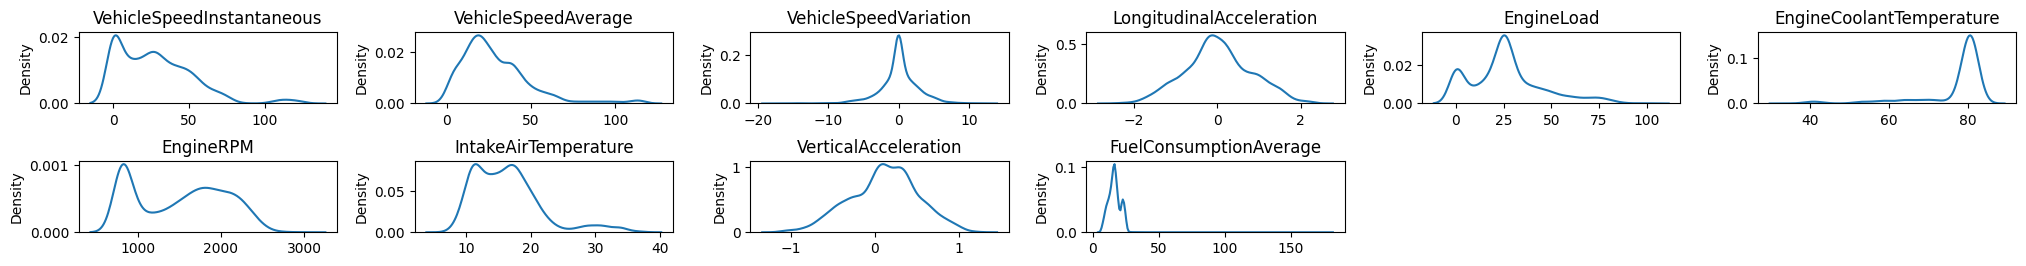

In [159]:
plt.figure(figsize=(25,21))

i = 1

for col in df[features].columns:
    plt.subplot(13,6,i)
    a = sns.kdeplot(df[col])
    plt.title(col)
    plt.xlabel('')
    plt.subplots_adjust(hspace=0.8)
    plt.subplots_adjust(wspace=0.3)
    i += 1

### Porcentagem de cada classe no conjunto de dados



In [160]:
target_count = labels.value_counts()
display((target_count/len(df)*100).round(2).to_frame("Estilo de direção" +" (%)").T)

EvenPaceStyle  AggressiveStyle
Estilo de direção (%)          55.22            44.78

# Modelos

## DecisionTreeClassifier

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [168]:
# Agora vou criar um modelo de DecisionTreeClassifier usando o scikit-learn.

# Cria o objeto da arvore de decisão
clf = DecisionTreeClassifier()

# Treinamento
clf = clf.fit(X_train,y_train)

# Resultados
y_predicao = clf.predict(X_test) 

acuracia_arvore_decisao = metrics.accuracy_score(y_test, y_predicao)

In [169]:
print(acuracia_arvore_decisao)

# Tivemos uma acurácia de 89,38%, o que é considerado uma ótima acurácia

0.8338907469342252


In [170]:
# Vamos visualizar a árvore de decisão

dot_data = StringIO()

export_graphviz(
    clf, out_file=dot_data, filled=True, rounded=True,
    special_characters=True, 
    feature_names = features,
    class_names=['EvenPaceStyle','AggressiveStyle']
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('arvore_sem_otimização.png')

Image(graph.create_png())

Utilizando o critério de entropia



0.7112597547380156


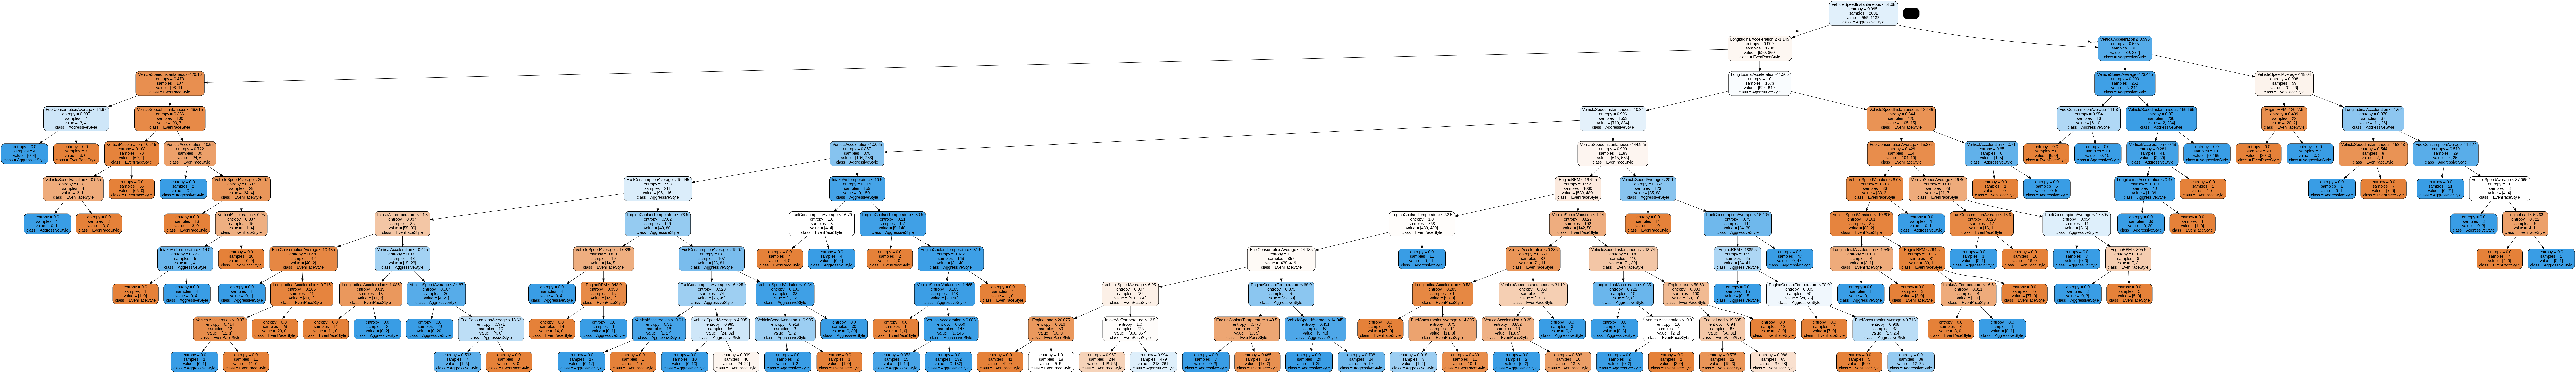

In [175]:
# https://www.datacamp.com/tutorial/decision-tree-classification-python

clf = DecisionTreeClassifier(criterion="entropy", max_depth=10)

clf = clf.fit(X_train,y_train)

y_predicao = clf.predict(X_test) 

acuracia_arvore_decisao = metrics.accuracy_score(y_test, y_predicao)

print(acuracia_arvore_decisao)

dot_data = StringIO()

export_graphviz(
    clf, out_file=dot_data, filled=True, rounded=True,
    special_characters=True, 
    feature_names = features,
    class_names=['EvenPaceStyle','AggressiveStyle']
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('arvore_com_otimização.png')

Image(graph.create_png())

## RandomForest

In [178]:
best = 0
ibest = 0
jbest = 0
for j in range(1,11):
  for i in range(1,51):
    model = RandomForestClassifier(max_depth=j,n_estimators=i,random_state=42)
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    #print(i,j,score)
    if (score >= best):
      ibest = i
      jbest = j
      best = score
print("Número de árvores: " + str(ibest))
print("Profundidade máxima: " + str(jbest))
print("Acurácia: " + str(best))

Número de árvores: 23
Profundidade máxima: 10
Acurácia: 0.850613154960981


In [180]:
model = RandomForestClassifier(max_depth=jbest,n_estimators=ibest,random_state=42)
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.850613154960981

In [197]:
predict = model.predict(X_test)
classes = ['EvenPaceStyle','AggressiveStyle']

print(classification_report(y_test,predict))

                 precision    recall  f1-score   support

AggressiveStyle       0.79      0.88      0.83       379
  EvenPaceStyle       0.90      0.83      0.87       518

       accuracy                           0.85       897
      macro avg       0.85      0.85      0.85       897
   weighted avg       0.86      0.85      0.85       897



In [200]:
def matriz_confusao(y_val, y_pred,classes):
    cm = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
        title="Matriz de Confusão",
        ylabel="Rótulo Verdadeiro",
        xlabel="Previsão")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()

matriz_confusao(y_test,predict,classes)

In [202]:
for name, importance in zip(df[features], model.feature_importances_):
    print(name, "=", importance)

VehicleSpeedInstantaneous = 0.19166060969042603
VehicleSpeedAverage = 0.14576116354036908
VehicleSpeedVariation = 0.05813838762506893
LongitudinalAcceleration = 0.13070637622659492
EngineLoad = 0.04789550012805727
EngineCoolantTemperature = 0.05429571036290138
EngineRPM = 0.0787123311740152
IntakeAirTemperature = 0.05806064900880266
VerticalAcceleration = 0.10843155000384799
FuelConsumptionAverage = 0.12633772223991654


In [204]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,20))
plt.title("Feature importances")
plt.barh(range(len(importances[indices])), importances[indices],
       color="r", align="center")
plt.yticks(range(len(importances[indices])), X.columns[indices]) #df[features]
plt.show()

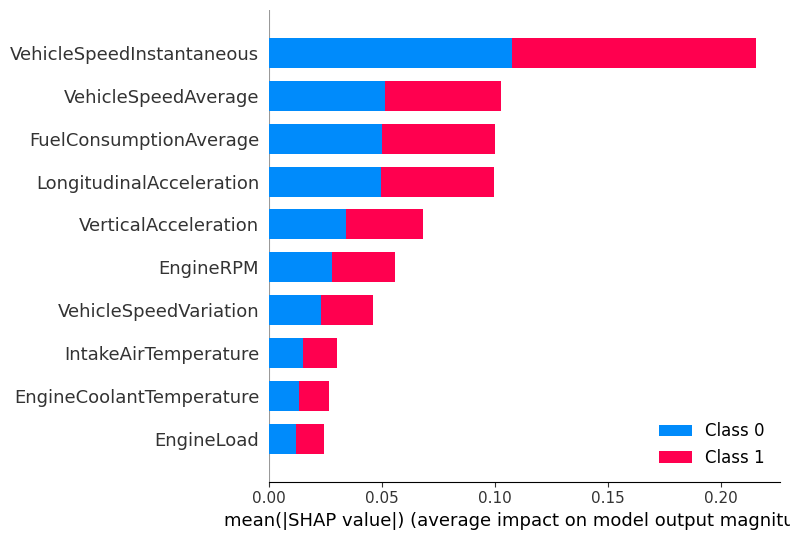

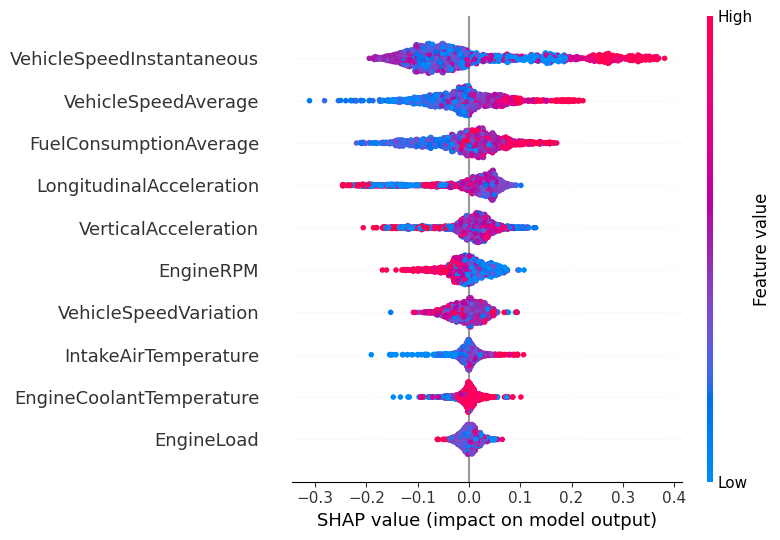

In [210]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values[1], X_train)

## XGBoost

In [213]:
best = 0
ibest = 0
jbest = 0

for j in range(1,6):
  for i in range(1,51):
    model = xgb.XGBClassifier(max_depth=j,n_estimators=i,random_state=15)
    model.fit(X_train,y_train)
    score = model.score(X_test.values,y_test)
    #print(i,j,score)
    if (score >= best):
      ibest = i
      jbest = j
      best = score
print("Número de árvores: " + str(ibest))
print("Profundidade máxima: " + str(jbest))
print("Acurácia: " + str(best))

ValueError: ignored

In [ ]:
model = xgb.XGBClassifier(max_depth=jbest,n_estimators=ibest,random_state=42)
model.fit(X_train,y_train)
model.score(X_test.values, y_test)

In [ ]:
predict = model.predict(X_test)
classes = ['EvenPaceStyle','AggressiveStyle']

print(classification_report(y_test,predict))

In [ ]:
matriz_confusao(y_test,predict,classes)

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,20))
plt.title("Feature importances")
plt.barh(range(len(importances[indices])), importances[indices],
       color="r", align="center")
plt.yticks(range(len(importances[indices])), X.columns[indices]) #df[features]
plt.show()

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values[1], X_train)

In [215]:
from sklearn.svm import SVC

acc = []
custo = [0.001,0.01,0.05,0.1,0.5,1,10]
for c in custo:
    model_svc = SVC(C=c, kernel='rbf', gamma='scale', probability=True)
    model_svc.fit(X_train,y_train)
    acc.append(model_svc.score(X_test,y_test))
    
print('Acurácia: ' + str(np.max(acc)))
print('Parâmetro C: ',custo[int(np.argmax(acc))])

Acurácia: 0.6086956521739131
Parâmetro C:  10


In [216]:
c = custo[int(np.argmax(acc))]
model = SVC(C=c, kernel='rbf', gamma='scale', probability=True)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.6086956521739131

In [217]:
predict = model.predict(X_test)
classes = ['EvenPaceStyle','AggressiveStyle']

print(classification_report(y_test,predict))

                 precision    recall  f1-score   support

AggressiveStyle       0.56      0.37      0.44       379
  EvenPaceStyle       0.63      0.78      0.70       518

       accuracy                           0.61       897
      macro avg       0.59      0.58      0.57       897
   weighted avg       0.60      0.61      0.59       897



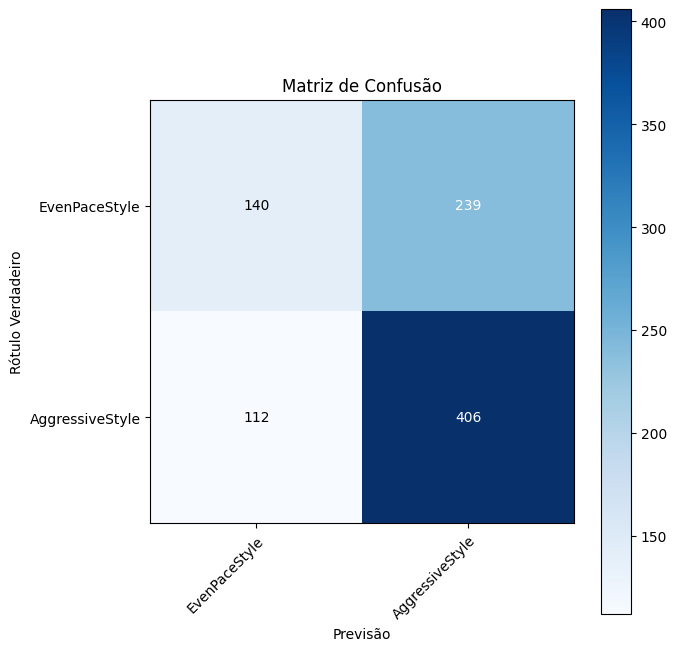

In [218]:
matriz_confusao(y_test,predict,classes)